In [1]:
!pip install pyspark

In [2]:
!sudo apt update

Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease [18.1 kB]
Hit:6 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:7 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:8 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:9 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1,245 kB]
Get:10 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [2,901 kB]
Get:11 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:12 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:13 https://developer.download.nvidia.com

In [3]:
!sudo apt install -y openjdk-11-jdk

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  fonts-dejavu-core fonts-dejavu-extra libatk-wrapper-java
  libatk-wrapper-java-jni libxt-dev libxtst6 libxxf86dga1 openjdk-11-jre
  x11-utils
Suggested packages:
  libxt-doc openjdk-11-demo openjdk-11-source visualvm mesa-utils
The following NEW packages will be installed:
  fonts-dejavu-core fonts-dejavu-extra libatk-wrapper-java
  libatk-wrapper-java-jni libxt-dev libxtst6 libxxf86dga1 openjdk-11-jdk
  openjdk-11-jre x11-utils
0 upgraded, 10 newly installed, 0 to remove and 34 not upgraded.
Need to get 6,920 kB of archives.
After this operation, 16.9 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 fonts-dejavu-core all 2.37-2build1 [1,041 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 fonts-dejavu-extra all 2.37-2build1 [2,041 kB]
Get:3 http://archive.ubuntu.com/ubuntu jam

In [4]:
!java -version


openjdk version "11.0.27" 2025-04-15
OpenJDK Runtime Environment (build 11.0.27+6-post-Ubuntu-0ubuntu122.04)
OpenJDK 64-Bit Server VM (build 11.0.27+6-post-Ubuntu-0ubuntu122.04, mixed mode, sharing)


### Import Libraries

In [52]:
from pyspark.sql import SparkSession

from pyspark.sql.functions import (
    count, when, col, mean, sum, length, to_timestamp,
    hour, dayofweek, month, year, unix_timestamp, rand, isnan, isnull
)
from pyspark.sql.types import DoubleType
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.regression import RandomForestRegressor, LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
import matplotlib.pyplot as plt

In [53]:
spark = SparkSession.builder \
    .appName("NYC_Taxi_Trip_Data_Analysis") \
    .config("spark.executor.memory", "10g") \
    .config("spark.driver.memory", "10g") \
    .config("spark.sql.adaptive.enabled", "true") \
    .getOrCreate()
spark.sparkContext.setLogLevel("ERROR")

In [56]:
file_paths = [
    "yellow_tripdata_2023-09.parquet",
    "yellow_tripdata_2023-10.parquet",
    "yellow_tripdata_2023-11.parquet",
    "yellow_tripdata_2023-12.parquet"
]

In [57]:
df = spark.read.parquet(file_paths[0])
for path in file_paths[1:]:
    new_df = spark.read.parquet(path)
    df = df.union(new_df)

In [58]:
df.count()

13085289

In [59]:
df.cache()

DataFrame[VendorID: int, tpep_pickup_datetime: timestamp_ntz, tpep_dropoff_datetime: timestamp_ntz, passenger_count: bigint, trip_distance: double, RatecodeID: bigint, store_and_fwd_flag: string, PULocationID: int, DOLocationID: int, payment_type: bigint, fare_amount: double, extra: double, mta_tax: double, tip_amount: double, tolls_amount: double, improvement_surcharge: double, total_amount: double, congestion_surcharge: double, Airport_fee: double]

### Exploratory Data Analysis

In [60]:
df.show()

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|Airport_fee|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|       1| 2023-09-01 00:15:37|  2023-09-01 00:20:21|              1|          0.8|         1|                 N|         163|         230|           2|        6.5|  3.5|    0.5|       0.

In [12]:
df.printSchema()

root
 |-- VendorID: integer (nullable = true)
 |-- tpep_pickup_datetime: timestamp_ntz (nullable = true)
 |-- tpep_dropoff_datetime: timestamp_ntz (nullable = true)
 |-- passenger_count: long (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: long (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: integer (nullable = true)
 |-- DOLocationID: integer (nullable = true)
 |-- payment_type: long (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- Airport_fee: double (nullable = true)



In [13]:
df.describe().show()

+-------+-------------------+------------------+------------------+------------------+------------------+-----------------+-----------------+------------------+------------------+------------------+-------------------+-----------------+------------------+---------------------+------------------+--------------------+------------------+
|summary|           VendorID|   passenger_count|     trip_distance|        RatecodeID|store_and_fwd_flag|     PULocationID|     DOLocationID|      payment_type|       fare_amount|             extra|            mta_tax|       tip_amount|      tolls_amount|improvement_surcharge|      total_amount|congestion_surcharge|       Airport_fee|
+-------+-------------------+------------------+------------------+------------------+------------------+-----------------+-----------------+------------------+------------------+------------------+-------------------+-----------------+------------------+---------------------+------------------+--------------------+---------

In [14]:
df.summary().show()

+-------+-------------------+------------------+------------------+------------------+------------------+-----------------+-----------------+------------------+------------------+------------------+-------------------+-----------------+------------------+---------------------+------------------+--------------------+------------------+
|summary|           VendorID|   passenger_count|     trip_distance|        RatecodeID|store_and_fwd_flag|     PULocationID|     DOLocationID|      payment_type|       fare_amount|             extra|            mta_tax|       tip_amount|      tolls_amount|improvement_surcharge|      total_amount|congestion_surcharge|       Airport_fee|
+-------+-------------------+------------------+------------------+------------------+------------------+-----------------+-----------------+------------------+------------------+------------------+-------------------+-----------------+------------------+---------------------+------------------+--------------------+---------

In [15]:
#Columns with NULL values

#Drop columns like RatecodeID, store_and_fwd_flag and impute the other NULL columns
df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|Airport_fee|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|       0|                   0|                    0|         607832|            0|    607832|            607832|           0|           0|           0|          0|    0|      0|         

In [16]:
df.groupBy("passenger_count").count().show()

+---------------+-------+
|passenger_count|  count|
+---------------+-------+
|              0| 169663|
|              7|     46|
|              6| 100353|
|              9|     18|
|              5| 159440|
|              1|9399517|
|              3| 460603|
|              8|    118|
|              2|1913311|
|              4| 274388|
|           NULL| 607832|
+---------------+-------+



In [17]:
df.groupBy("congestion_surcharge").count().show()

+--------------------+--------+
|congestion_surcharge|   count|
+--------------------+--------+
|                 0.0|  934654|
|                 2.5|11425735|
|                0.75|       2|
|                -2.5|  117065|
|                NULL|  607832|
|                 0.5|       1|
+--------------------+--------+



In [18]:
df.groupBy("Airport_fee").count().show()


+-----------+--------+
|Airport_fee|   count|
+-----------+--------+
|        0.0|11363600|
|      -1.75|   19262|
|       1.75| 1094594|
|       NULL|  607832|
|       1.25|       1|
+-----------+--------+



In [19]:
# Check for duplicate rows
total_count = df.count()
unique_count = df.dropDuplicates().count()

if total_count > unique_count:
    print(f"There are {total_count - unique_count} duplicate rows.")
else:
    print("There are no duplicate rows.")


There are 2 duplicate rows.


In [20]:
from pyspark.sql.functions import col, when

# Define numerical columns
numerical_columns = ["trip_distance", "fare_amount", "extra", "mta_tax", "tip_amount",
                     "tolls_amount", "improvement_surcharge", "total_amount",
                     "congestion_surcharge", "Airport_fee", "passenger_count"]

outlier_columns = []
for column in numerical_columns:
    quantiles = df.approxQuantile(column, [0.25, 0.75], 0.0)
    Q1, Q3 = quantiles[0], quantiles[1]
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Check if there are any outliers in the current column
    outlier_count = df.filter((col(column) < lower_bound) | (col(column) > upper_bound)).count()
    if outlier_count > 0:
        outlier_columns.append(column)

if outlier_columns:
    print(f"Columns with outliers: {outlier_columns}")
    df.select(outlier_columns).show()
else:
    print("No columns with outliers found.")


Columns with outliers: ['trip_distance', 'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge', 'total_amount', 'congestion_surcharge', 'Airport_fee', 'passenger_count']
+-------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+---------------+
|trip_distance|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|Airport_fee|passenger_count|
+-------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+---------------+
|          0.8|        6.5|  3.5|    0.5|       0.0|         0.0|                  1.0|        11.5|                 2.5|        0.0|              1|
|         2.34|       14.2|  1.0|    0.5|       2.0|         0.0|                  1.0|        21.2|                 2.5|        0.0|              2|
|         1.62|        8.6|  1.0|    0.5|    

### Preprocessing

In [21]:
df = df.na.drop(subset=["RatecodeID", "store_and_fwd_flag"])

In [22]:
## Mean imputation for passenger_count, congestion_surcharge, and Airport_fee column

mean_values = df.select(
    mean("passenger_count").alias("mean_passenger_count"),
    mean("congestion_surcharge").alias("mean_congestion_surcharge"),
    mean("Airport_fee").alias("mean_airport_fee")
).collect()[0]

# Impute null values with the calculated means
df = df.na.fill({
    "passenger_count": mean_values["mean_passenger_count"],
    "congestion_surcharge": mean_values["mean_congestion_surcharge"],
    "Airport_fee": mean_values["mean_airport_fee"]
})


In [23]:
# Outlier Handling
# List of columns with outliers
outlier_columns = ["trip_distance", "fare_amount", "extra", "mta_tax", "tip_amount",
                   "tolls_amount", "improvement_surcharge", "total_amount",
                   "congestion_surcharge", "Airport_fee", "passenger_count"]

# Filter conditions for each column based on IQR
for column in outlier_columns:
    # Calculate the 25th and 75th percentiles
    quantiles = df.approxQuantile(column, [0.25, 0.75], 0.0)
    Q1, Q3 = quantiles[0], quantiles[1]
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Apply the filter to remove rows outside the acceptable range for this column
    df = df.filter((col(column) >= lower_bound) & (col(column) <= upper_bound))


In [24]:
df.describe().show()

+-------+------------------+---------------+------------------+-------------------+------------------+------------------+-----------------+-------------------+------------------+------------------+-------+------------------+------------+---------------------+------------------+--------------------+-----------+
|summary|          VendorID|passenger_count|     trip_distance|         RatecodeID|store_and_fwd_flag|      PULocationID|     DOLocationID|       payment_type|       fare_amount|             extra|mta_tax|        tip_amount|tolls_amount|improvement_surcharge|      total_amount|congestion_surcharge|Airport_fee|
+-------+------------------+---------------+------------------+-------------------+------------------+------------------+-----------------+-------------------+------------------+------------------+-------+------------------+------------+---------------------+------------------+--------------------+-----------+
|  count|           7422437|        7422437|           7422437| 

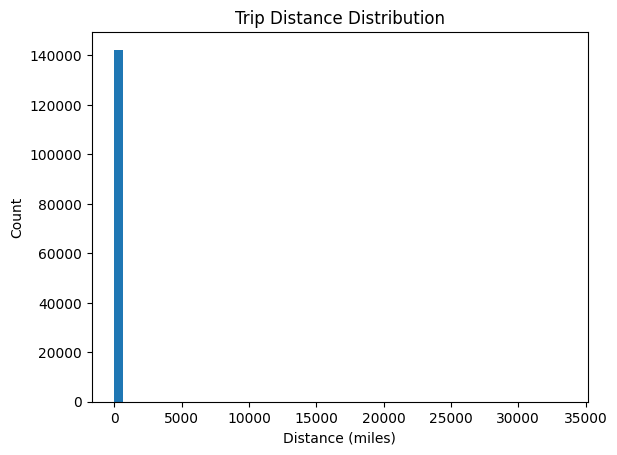

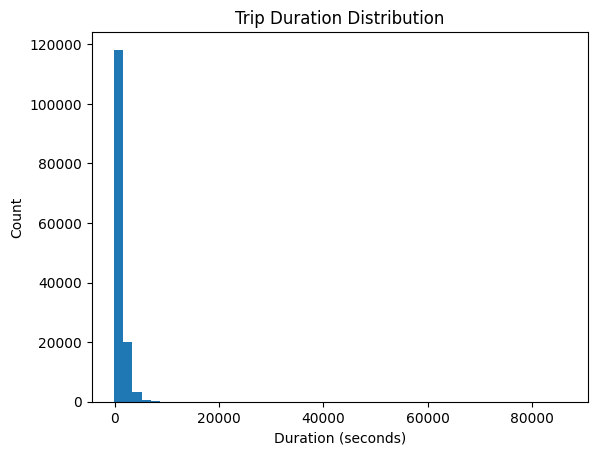

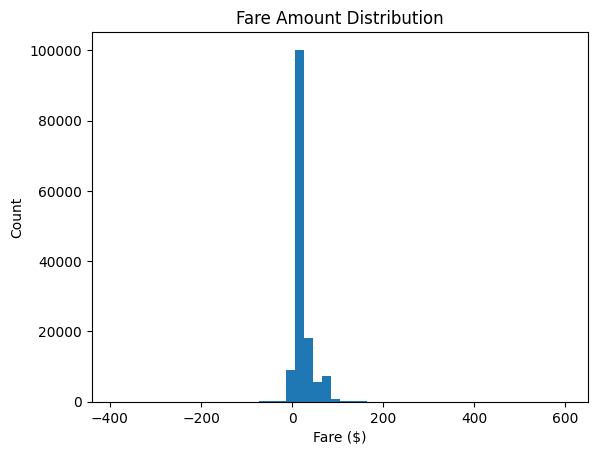

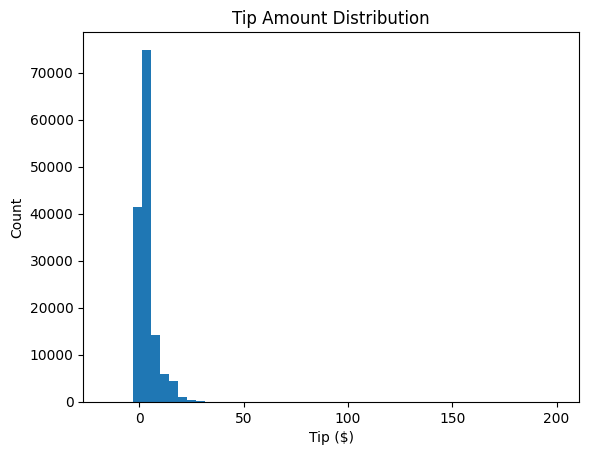

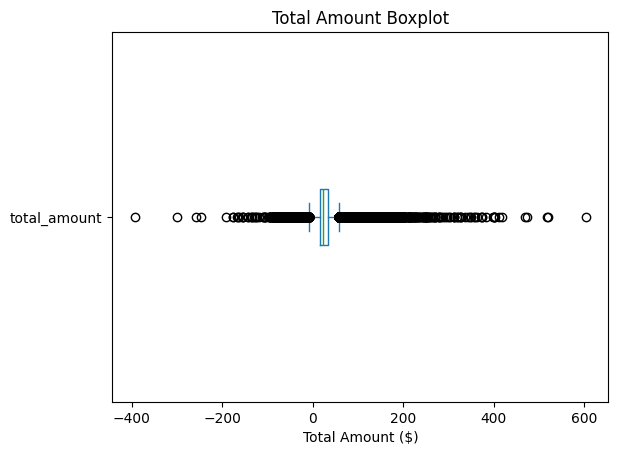

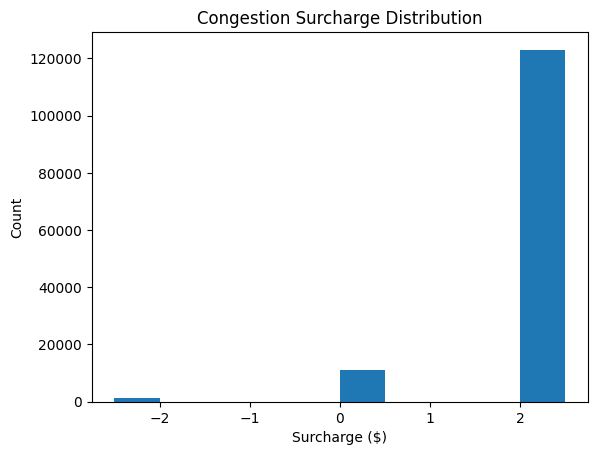

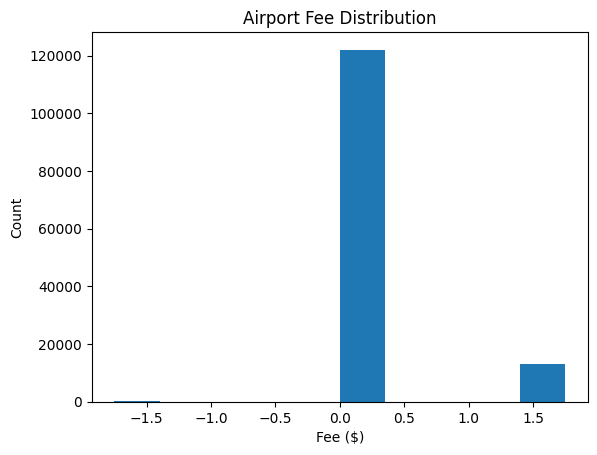

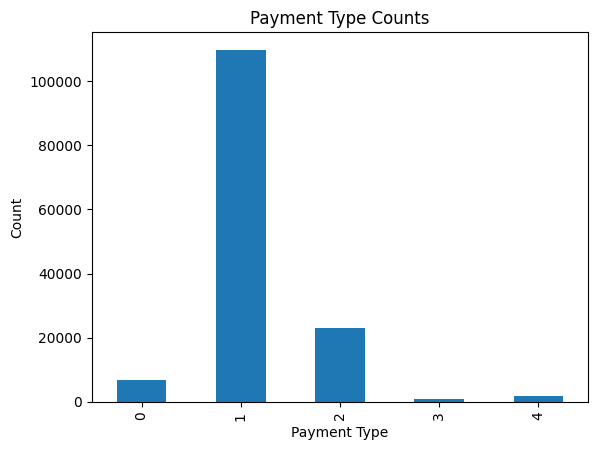

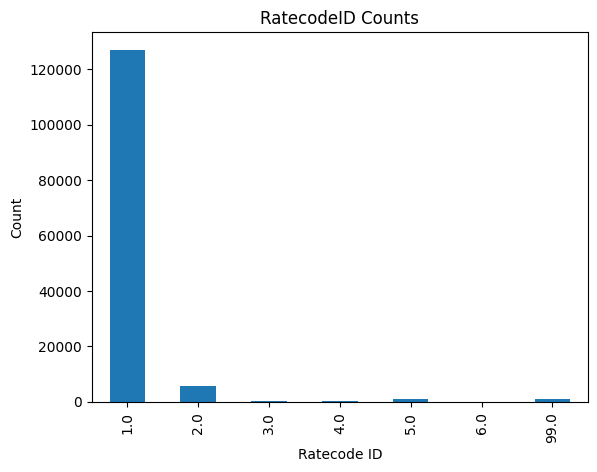

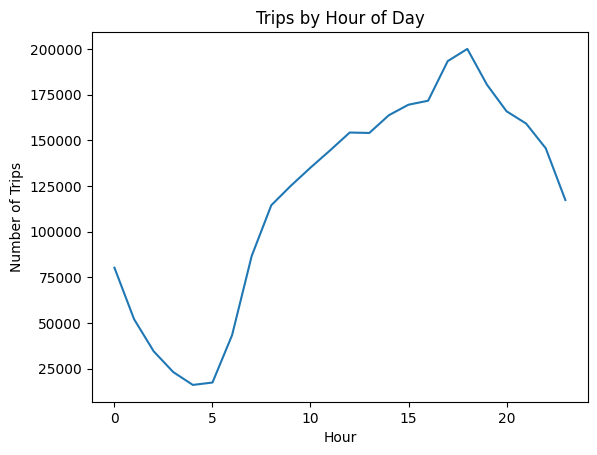

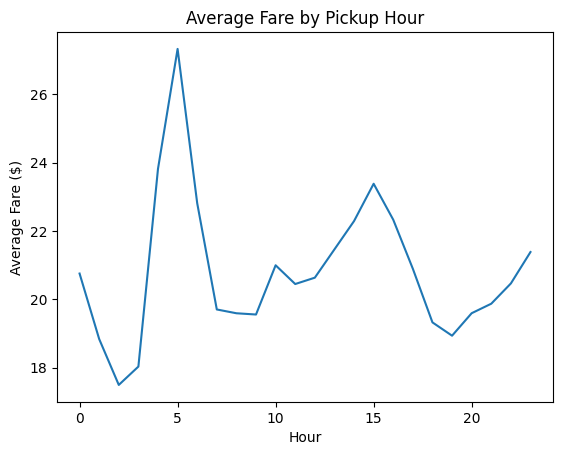

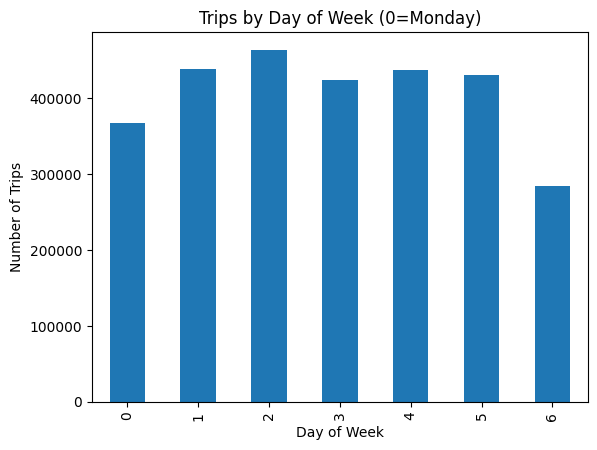

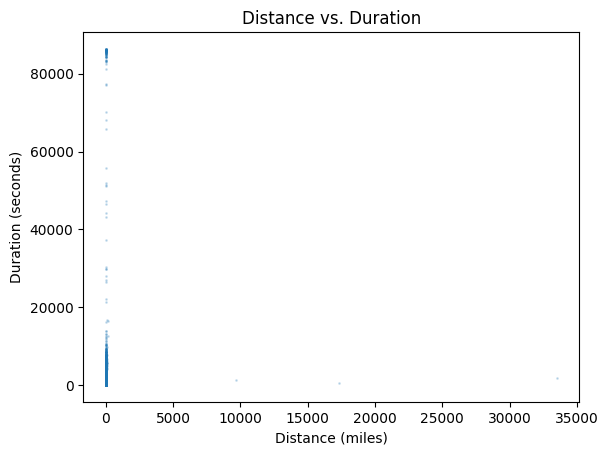

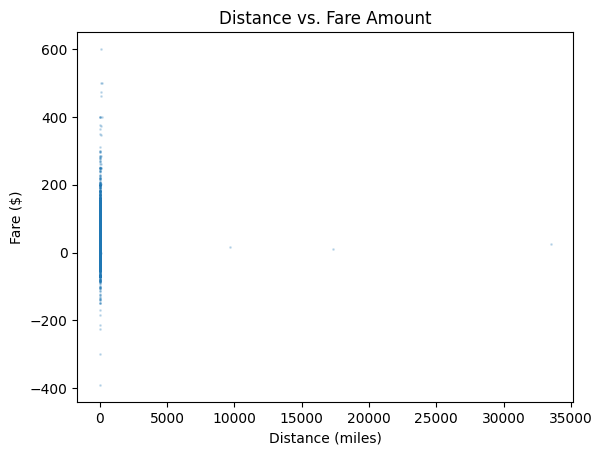

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# 0. Adjust this path
PARQUET_PATH = '/content/yellow_tripdata_2023-09.parquet'

# 1. Load into pandas
df = pd.read_parquet(PARQUET_PATH, engine="pyarrow")

# 2. Derive trip_duration in seconds
df['trip_duration'] = (
    df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']
).dt.total_seconds()

# 3. (Optional) sample 5% to speed plotting
sample = df.sample(frac=0.05, random_state=42)



In [ ]:
# 1) Trip Distance Histogram
plt.figure()
sample['trip_distance'].plot.hist(bins=50)
plt.title("Trip Distance Distribution")
plt.xlabel("Distance (miles)")
plt.ylabel("Count")
plt.show()



In [ ]:
# 2) Trip Duration Histogram
plt.figure()
sample['trip_duration'].plot.hist(bins=50)
plt.title("Trip Duration Distribution")
plt.xlabel("Duration (seconds)")
plt.ylabel("Count")
plt.show()



In [ ]:
# 3) Fare Amount Histogram
plt.figure()
sample['fare_amount'].plot.hist(bins=50)
plt.title("Fare Amount Distribution")
plt.xlabel("Fare ($)")
plt.ylabel("Count")
plt.show()



In [ ]:
# 4) Tip Amount Histogram
plt.figure()
sample['tip_amount'].plot.hist(bins=50)
plt.title("Tip Amount Distribution")
plt.xlabel("Tip ($)")
plt.ylabel("Count")
plt.show()



In [ ]:
# 5) Total Amount Boxplot
plt.figure()
sample['total_amount'].plot.box(vert=False)
plt.title("Total Amount Boxplot")
plt.xlabel("Total Amount ($)")
plt.show()



In [ ]:
# 6) Congestion Surcharge Histogram
plt.figure()
sample['congestion_surcharge'].dropna().plot.hist(bins=10)
plt.title("Congestion Surcharge Distribution")
plt.xlabel("Surcharge ($)")
plt.ylabel("Count")
plt.show()

In [ ]:

# 7) Airport Fee Histogram
plt.figure()
sample['Airport_fee'].dropna().plot.hist(bins=10)
plt.title("Airport Fee Distribution")
plt.xlabel("Fee ($)")
plt.ylabel("Count")
plt.show()

In [ ]:
# 8) Payment Type Bar Chart
plt.figure()
sample['payment_type'].value_counts().sort_index().plot.bar()
plt.title("Payment Type Counts")
plt.xlabel("Payment Type")
plt.ylabel("Count")
plt.show()

In [ ]:

# 9) RatecodeID Bar Chart
plt.figure()
sample['RatecodeID'].value_counts().sort_index().plot.bar()
plt.title("RatecodeID Counts")
plt.xlabel("Ratecode ID")
plt.ylabel("Count")
plt.show()


In [ ]:
# 10) Trips by Hour of Day
hourly = df['tpep_pickup_datetime'].dt.hour.value_counts().sort_index()
plt.figure()
hourly.plot.line()
plt.title("Trips by Hour of Day")
plt.xlabel("Hour")
plt.ylabel("Number of Trips")
plt.show()


In [ ]:
# 11) Average Fare by Hour
avg_fare_hour = df.groupby(df['tpep_pickup_datetime'].dt.hour)['fare_amount'].mean()
plt.figure()
avg_fare_hour.plot.line()
plt.title("Average Fare by Pickup Hour")
plt.xlabel("Hour")
plt.ylabel("Average Fare ($)")
plt.show()


In [ ]:
# 12) Trips by Day of Week
dow = df['tpep_pickup_datetime'].dt.dayofweek.value_counts().sort_index()
plt.figure()
dow.plot.bar()
plt.title("Trips by Day of Week (0=Monday)")
plt.xlabel("Day of Week")
plt.ylabel("Number of Trips")
plt.show()

In [ ]:

# 13) Scatter: Distance vs. Duration
plt.figure()
plt.scatter(sample['trip_distance'], sample['trip_duration'], s=1, alpha=0.2)
plt.title("Distance vs. Duration")
plt.xlabel("Distance (miles)")
plt.ylabel("Duration (seconds)")
plt.show()

In [ ]:

# 14) Scatter: Distance vs. Fare
plt.figure()
plt.scatter(sample['trip_distance'], sample['fare_amount'], s=1, alpha=0.2)
plt.title("Distance vs. Fare Amount")
plt.xlabel("Distance (miles)")
plt.ylabel("Fare ($)")
plt.show()


### Feature Engineering

In [ ]:
# 1. Extract meaningful date and time features from 'tpep_pickup_datetime'

# Extract hour, day of week, month, and year
df = df.withColumn("pickup_hour", hour("tpep_pickup_datetime")) \
       .withColumn("pickup_dayofweek", dayofweek("tpep_pickup_datetime")) \
       .withColumn("pickup_month", month("tpep_pickup_datetime")) \
       .withColumn("pickup_year", year("tpep_pickup_datetime"))

# Calculate trip duration (in minutes) using 'tpep_pickup_datetime' and 'tpep_dropoff_datetime'
df = df.withColumn("trip_duration",
                   (unix_timestamp("tpep_dropoff_datetime") - unix_timestamp("tpep_pickup_datetime")) / 60)

# 2. Interaction Features
# Create features that represent interactions between columns

df = df.withColumn("distance_per_passenger", col("trip_distance") / col("passenger_count"))
df = df.withColumn("fare_per_distance", col("fare_amount") / col("trip_distance"))
df = df.withColumn("total_per_passenger", col("total_amount") / col("passenger_count"))

# 3. Aggregated Features
# Aggregations based on locations might be useful if there's a logical grouping for PULocationID

location_aggregates = df.groupBy("PULocationID").agg(
    mean("fare_amount").alias("avg_fare_by_location"),
    mean("trip_duration").alias("avg_duration_by_location")
)
df = df.join(location_aggregates, on="PULocationID", how="left")


In [ ]:
df.show(5)

+------------+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+-----------+----------------+------------+-----------+------------------+----------------------+-----------------+-------------------+--------------------+------------------------+
|PULocationID|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|Airport_fee|pickup_hour|pickup_dayofweek|pickup_month|pickup_year|     trip_duration|distance_per_passenger|fare_per_distance|total_per_passenger|avg_fare_by_location|avg_duration_by_location|
+------------+--------+--------------------+---------------------+---------------+-------------+--

### Check feature importance for fare price prediction

In [ ]:
input_features = ["PULocationID", "VendorID", "passenger_count", "trip_distance", "RatecodeID",
                  "DOLocationID", "payment_type", "extra", "mta_tax", "tip_amount",
                  "tolls_amount", "improvement_surcharge", "congestion_surcharge",
                  "Airport_fee", "pickup_hour", "pickup_dayofweek", "pickup_month",
                  "pickup_year", "trip_duration", "distance_per_passenger",
                  "fare_per_distance", "total_per_passenger", "avg_fare_by_location",
                  "avg_duration_by_location"]
for feature in input_features:
    correlation = df.stat.corr("fare_amount", feature)
    print(f"Correlation between fare_amount and {feature}: {correlation}")


Correlation between fare_amount and PULocationID: -0.054749987830381076
Correlation between fare_amount and VendorID: 0.031202118350427854
Correlation between fare_amount and passenger_count: nan
Correlation between fare_amount and trip_distance: 0.8425956403846812
Correlation between fare_amount and RatecodeID: -0.00040374772095564716
Correlation between fare_amount and DOLocationID: -0.07688439820938583
Correlation between fare_amount and payment_type: -0.04221477223724735
Correlation between fare_amount and extra: -0.028096328693447963
Correlation between fare_amount and mta_tax: nan
Correlation between fare_amount and tip_amount: 0.4249871823417523
Correlation between fare_amount and tolls_amount: nan
Correlation between fare_amount and improvement_surcharge: nan
Correlation between fare_amount and congestion_surcharge: nan
Correlation between fare_amount and Airport_fee: nan
Correlation between fare_amount and pickup_hour: 0.030176398899127026
Correlation between fare_amount and p

In [ ]:
# Define target and selected input features to retain
target_column = "fare_amount"
selected_features = [
    "trip_distance", "tip_amount", "trip_duration", "distance_per_passenger",
    "fare_per_distance", "total_per_passenger", "avg_fare_by_location",
    "avg_duration_by_location"
]

# Retain only the selected features and the target column
columns_to_keep = [target_column] + selected_features
df = df.select(*columns_to_keep)



In [ ]:
# Display the schema to verify the DataFrame structure
df.printSchema()

root
 |-- fare_amount: double (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- trip_duration: double (nullable = true)
 |-- distance_per_passenger: double (nullable = true)
 |-- fare_per_distance: double (nullable = true)
 |-- total_per_passenger: double (nullable = true)
 |-- avg_fare_by_location: double (nullable = true)
 |-- avg_duration_by_location: double (nullable = true)



### Building Linear Regression model

In [ ]:
df = df.drop("features", "out_features")


In [ ]:
df.printSchema()

root
 |-- fare_amount: double (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- trip_duration: double (nullable = true)
 |-- distance_per_passenger: double (nullable = true)
 |-- fare_per_distance: double (nullable = true)
 |-- total_per_passenger: double (nullable = true)
 |-- avg_fare_by_location: double (nullable = true)
 |-- avg_duration_by_location: double (nullable = true)



In [ ]:
# Step 1: Ensure the target column and selected features are cast to DoubleType
for column in [target_column] + selected_features:
    df = df.withColumn(column, col(column).cast(DoubleType()))

# Step 2: Remove rows with NaN, null, or infinite values in selected columns
for column in [target_column] + selected_features:
    df = df.filter(~isnan(col(column)) & ~isnull(col(column)) & (col(column) != float("inf")) & (col(column) != float("-inf")))

# Step 3: Assemble selected features into a single feature vector
assembler = VectorAssembler(inputCols=selected_features, outputCol="features")
df = assembler.transform(df)

# Step 4: Normalize the feature vector
scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withMean=True, withStd=True)
scaler_model = scaler.fit(df)
df = scaler_model.transform(df)

train, test = df.randomSplit([0.8, 0.2], seed=42)

lr = LinearRegression(featuresCol="scaled_features", labelCol=target_column)

lr_model = lr.fit(train)

predictions = lr_model.transform(test)

# Step 9: Evaluate the model's performance using RMSE
evaluator = RegressionEvaluator(labelCol=target_column, predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print(f"Root Mean Squared Error (RMSE) on test data: {rmse}")



Root Mean Squared Error (RMSE) on test data: 0.9192146006468779


In [ ]:
from pyspark.sql.functions import rand

random_predictions = predictions.select(target_column, "prediction").orderBy(rand()).limit(10)

random_predictions.show()


+-----------+------------------+
|fare_amount|        prediction|
+-----------+------------------+
|        5.1| 6.905348200892792|
|        8.6|7.9837805732082785|
|       11.4|11.071707827797274|
|       23.3| 22.39429366992435|
|       12.8|12.251253789360483|
|       12.8|12.101341654625795|
|        7.9|7.3459649518781145|
|       21.2|19.987029936518162|
|       21.9|20.606016681282178|
|       24.0|24.870190967075224|
+-----------+------------------+



#### Relative RMSE tells us that the predicted fare amount on an average varies by 7.38% from the actual value

In [ ]:
# Calculate the mean of fare_amount in the test set
mean_fare = test.select("fare_amount").groupBy().avg().first()[0]

# Calculate relative RMSE as a percentage
relative_rmse = (rmse / mean_fare) * 100
print(f"Relative RMSE: {relative_rmse:.2f}%")


Relative RMSE: 6.88%


In [ ]:
df.printSchema()

root
 |-- fare_amount: double (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- trip_duration: double (nullable = true)
 |-- distance_per_passenger: double (nullable = true)
 |-- fare_per_distance: double (nullable = true)
 |-- total_per_passenger: double (nullable = true)
 |-- avg_fare_by_location: double (nullable = true)
 |-- avg_duration_by_location: double (nullable = true)
 |-- features: vector (nullable = true)
 |-- scaled_features: vector (nullable = true)



### Checking for Overfitting or Underfitting

In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator

# Step 1: Calculate RMSE on the Training Data
train_predictions = lr_model.transform(train)
train_rmse = evaluator.evaluate(train_predictions, {evaluator.metricName: "rmse"})
print(f"Training RMSE: {train_rmse}")

# Step 2: Calculate RMSE on the Test Data
test_predictions = lr_model.transform(test)
test_rmse = evaluator.evaluate(test_predictions, {evaluator.metricName: "rmse"})
print(f"Test RMSE: {test_rmse}")


# Step 3: Analyze Overfitting or Underfitting
if train_rmse < test_rmse * 0.7:
    print("The model might be overfitting.")
elif train_rmse > test_rmse * 1.3:
    print("The model might be underfitting.")
else:
    print("The model seems to be well-fitted.")


Training RMSE: 0.9195495223229773
Test RMSE: 0.9192146006468779
The model seems to be well-fitted.


In [ ]:
spark.stop()

### Visualization Plots Using Hive

In [ ]:
# Save DataFrame as a temporary view
df.createOrReplaceTempView("NYC_Taxi_Trip_Data_Analysis")


In [ ]:
fare_vs_distance = spark.sql("""
    SELECT trip_distance, fare_amount
    FROM NYC_Taxi_Trip_Data_Analysis
    WHERE trip_distance < 50
""")

fare_vs_distance_df = fare_vs_distance.toPandas()

AnalysisException: [TABLE_OR_VIEW_NOT_FOUND] The table or view `NYC_Taxi_Trip_Data_Analysis` cannot be found. Verify the spelling and correctness of the schema and catalog.
If you did not qualify the name with a schema, verify the current_schema() output, or qualify the name with the correct schema and catalog.
To tolerate the error on drop use DROP VIEW IF EXISTS or DROP TABLE IF EXISTS.; line 3 pos 9;
'Project ['trip_distance, 'fare_amount]
+- 'Filter ('trip_distance < 50)
   +- 'UnresolvedRelation [NYC_Taxi_Trip_Data_Analysis], [], false


In [ ]:
# Hexbin plot
plt.figure(figsize=(10, 6))
plt.hexbin(fare_vs_distance_df["trip_distance"], fare_vs_distance_df["fare_amount"], gridsize=50, cmap="Blues")
plt.colorbar(label="Density")
plt.xlabel("Trip Distance")
plt.ylabel("Fare Amount")
plt.title("Fare Amount vs. Trip Distance (Hexbin Plot)")
plt.grid(True)
plt.show()

NameError: name 'fare_vs_distance_df' is not defined

<Figure size 1000x600 with 0 Axes>

In [ ]:
spark.stop()